```
%% This Matlab program integrats the optical flow method with the cross-correlation method
%% for extraction of high-resolution velocity fields from particle images.
%% This hybrid method provides an additional tool to process PIV images,
%% which combines the advantages of the optical flow method and cross-correlation method.

close all
clear all
clc

%% Load Images

% Im1=imread('I1_vortexpair_dt0p03.tif');
% Im2=imread('I2_vortexpair_dt0p03.tif');

% Im1=imread('I1_vortexpair_dt0p05.tif');
% Im2=imread('I2_vortexpair_dt0p05.tif');

% Im1=imread('wall_jet_1.tif');
% Im2=imread('wall_jet_2.tif');

% Im1=imread('twin_jet_1.tif');
% Im2=imread('twin_jet_2.tif');

Im1=imread('White_Oval_1.tif');
Im2=imread('White_Oval_2.tif');



%% Selete region of interest, "0" for processing the whole image, "1" for processing a selected region
index_region=0;

Im1=double(Im1);
Im2=double(Im2);

if (index_region == 1)
    imagesc(uint8(Im1));
    colormap(gray);
    axis image;

    xy=ginput(2);
    x1=floor(min(xy(:,1)));
    x2=floor(max(xy(:,1)));
    y1=floor(min(xy(:,2)));
    y2=floor(max(xy(:,2)));
    I1=double(Im1(y1:y2,x1:x2));
    I2=double(Im2(y1:y2,x1:x2));
elseif (index_region == 0)
    I1=Im1;
    I2=Im2;
end

I1_original=I1;
I2_original=I2;


%% Set the Parameters for Optical Flow Computation

% Set the lagrange multipleirs in optical computation
lambda_1=20;  % the Horn_schunck estimator for initial field
lambda_2=2000; % the Liu-Shen estimator for refined estimation

%% Number of iterations in the coarse-to-fine iterative process from
%% initial estimation, "1" means 1 iteration
no_iteration=1; % fixed

%% Initial coarse field estimation in the coarse-to-fine iterative process,
%% scale_im is a scale factor for down-sizing of images
scale_im=1;
%% For Image Pre-Processing

%% For local illumination intensity adjustment, To bypass it, set size_average = 0
size_average=0; % in pixels

%% Gausian filter size for removing random noise in images
size_filter=6; % in pixels

%% correcting the global and local intensity change in images
[m1,n1]=size(I1);
window_shifting=[1;n1;1;m1]; % [x1,x2,y1,y2] deines a rectangular window for global intensity correction
[I1,I2]=correction_illumination(I1,I2,window_shifting,size_average);


%% cleaning the left and upper edges since some data near the edges are corrupted due to interperlation
edge_width=1; % in pixels


%% pre-processing for reducing random noise,
%% and downsampling images if displacements are large
[I1,I2] = pre_processing_a(I1,I2,scale_im,size_filter);

I_region1=I1;
I_region2=I2;


%% initial correlation calculation for a coarse-grained velocity field (ux0,uy0)
% ux is the velocity (pixels/unit time) in the image x-coordinate (from the left-up corner to right)
% uy is the velocity (pixels/unit time) in the image y-coordinate (from the left-up corner to bottom)


%% run FFT cross-correlation algorithm
Im1=I1;
Im2=I2;

pivPar.iaSizeX = [64 16 8];     % size of interrogation area in X
pivPar.iaStepX = [32 8 4];       % grid spacing of velocity vectors in X

pivPar.ccMethod = 'fft';

[pivData1] = pivAnalyzeImagePair(Im1,Im2,pivPar);

ux0=pivData1.U;
uy0=pivData1.V;


%% re-size the initial velocity dield (u0, v0)
[n0,m0]=size(ux0);
[n1,m1]=size(Im1);

scale=round((n1*m1/(n0*m0))^0.5);

ux0=imresize(ux0,scale);
uy0=imresize(uy0,scale);


%% generate the shifted image from Im1 based on the initial coarse-grained velocity field (ux0, uy0),
%% and then calculate velocity difference for iterative correction


%% estimate the displacement vector and make correction in iterations

ux=ux0;
uy=uy0;

k=1;
while k<=no_iteration
   [Im1_shift,uxI,uyI]=shift_image_fun_refine_1(ux,uy,Im1,Im2);

    I1=double(Im1_shift);
    I2=double(Im2);

    % calculation of correction of the optical flow
    [dux,duy,vor,dux_horn,duy_horn,error2]=OpticalFlowPhysics_fun(I1,I2,lambda_1,lambda_2);

    % refined optical flow
    ux_corr=uxI+dux;
    uy_corr=uyI+duy;


    k=k+1;
end

%% refined velocity field
ux = ux_corr;    %%%%%
uy = uy_corr;    %%%%%



%% clean up the edges
ux(:,1:edge_width)=ux(:,(edge_width+1):(2*edge_width));
uy(:,1:edge_width)=uy(:,(edge_width+1):(2*edge_width));

ux(1:edge_width,:)=ux((edge_width+1):(2*edge_width),:);
uy(1:edge_width,:)=uy((edge_width+1):(2*edge_width),:);



%% show the images and processed results
%% plot the images, velocity vector, and streamlines in the initail and
%% refined estimations
 plots_set_1;

%% plot the fields of velocity magnitude, vorticity and the second invariant Q
 plots_set_2;


% save Ux_vortexpair_hybrid_dt0p2.dat ux -ascii;
% save Uy_vortexpair_hybrid_dt0p2.dat uy -ascii;
%
% save Ux_vortexpair_corr_dt0p2.dat ux0 -ascii;
% save Uy_vortexpair_corr_dt0p2.dat uy0 -ascii;
% %

```

In [1]:
import numpy as np
import imageio.v3 as imageio
import warnings
import re
from glob import glob
import time

# Configure NumPy to show the source of warnings
np.seterr(all='warn')
# Configure warnings to show the full stack trace
warnings.filterwarnings('always', category=RuntimeWarning)

from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import sys
import os
from typing import Tuple, List, Dict, Any

# Add current directory to Python path
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))

# Import from openopticalflow package
from openopticalflow.correction_illumination import correction_illumination
from openopticalflow.pre_processing_a import pre_processing_a
from openopticalflow.OpticalFlowPhysics_fun import OpticalFlowPhysics_fun
from openopticalflow.shift_image_fun_refine_1 import shift_image_fun_refine_1

# Import PIV analysis functions
from pivSuite.pivAnalyzeImagePair import piv_analyze_image_pair
from pivSuite.piv_parameters import PIVParameters


Successfully loaded White_Oval images


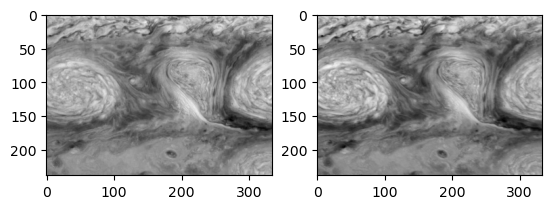

In [2]:

# Load Images

Im1 = imageio.imread('./images/White_Oval_1.tif')
Im2 = imageio.imread('./images/White_Oval_2.tif')
print("Successfully loaded White_Oval images")

fig, ax = plt.subplots(1,2)
ax[0].imshow(Im1, cmap='gray')
ax[1].imshow(Im2, cmap='gray')
plt.show()


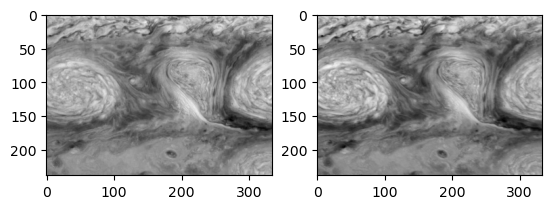

In [3]:

# Im1 = imageio.imread('./images/vortex_pair_particles_1.tif')
# Im2 = imageio.imread('./images/vortex_pair_particles_2.tif')
# print("Successfully loaded vortex_pair_particles images")

# Select region of interest
index_region = 0 # do not select ROI

Im1 = Im1.astype(np.float64)
Im2 = Im2.astype(np.float64)

if index_region == 1:
    plt.imshow(Im1, cmap='gray')
    plt.axis('image')
    xy = plt.ginput(2)
    plt.close()
    x1, x2 = int(min(xy[0][0], xy[1][0])), int(max(xy[0][0], xy[1][0]))
    y1, y2 = int(min(xy[0][1], xy[1][1])), int(max(xy[0][1], xy[1][1]))
    I1 = Im1[y1:y2, x1:x2]
    I2 = Im2[y1:y2, x1:x2]
else:
    I1 = Im1
    I2 = Im2

I1_original = I1 # preserve original images
I2_original = I2

# Set the Parameters for Optical Flow Computation
lambda_1 = 20
lambda_2 = 2000
no_iteration = 1
scale_im = 1
size_average = 0
size_filter = 6


# Correcting the global and local intensity change in images
m1, n1 = I1.shape
window_shifting = [1, n1, 1, m1]
I1, I2 = correction_illumination(I1, I2, window_shifting, size_average)

fig, ax = plt.subplots(1,2)
ax[0].imshow(I1, cmap='gray')
ax[1].imshow(I2, cmap='gray')
plt.show()


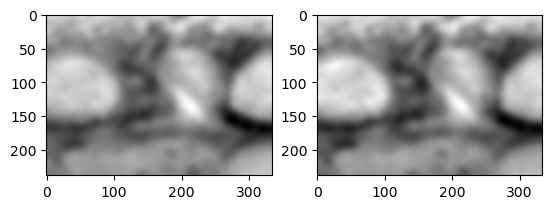

In [4]:
# Cleaning the left and upper edges
edge_width = 1

# Pre-processing for reducing random noise
I1, I2 = pre_processing_a(I1, I2, scale_im, size_filter)
I_region1 = I1
I_region2 = I2

fig, ax = plt.subplots(1,2)
ax[0].imshow(I_region1, cmap='gray')
ax[1].imshow(I_region2, cmap='gray')
plt.show()

Running PIV analysis...
PIV analysis complete. Keys in pivData1: ['N', 'Nx', 'Ny', 'Status', 'U', 'V', 'X', 'Y', 'ccFailedN', 'ccMean1', 'ccMean2', 'ccPeak', 'ccPeakSecondary', 'ccStd1', 'ccStd2', 'ccSubpxFailedN', 'iaSizeX', 'iaSizeY', 'iaStepX', 'iaStepY', 'imSizeX', 'imSizeY', 'infCompTime', 'infPassNo', 'maskedN', 'replacedN', 'smU', 'smV', 'spuriousN', 'spuriousU', 'spuriousV', 'spuriousX', 'spuriousY']
Velocity field shape: (28, 82, 1)


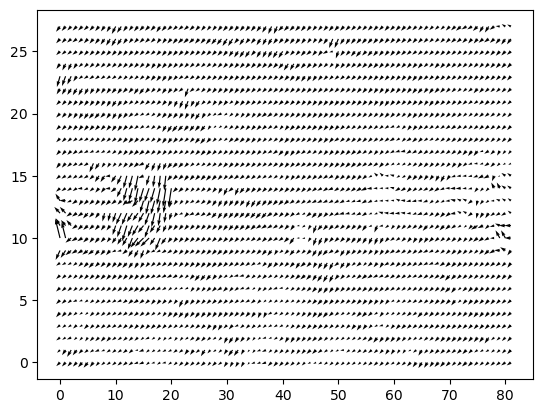

In [7]:
# Initial correlation calculation for a coarse-grained velocity field
pivPar = {
    'iaSizeX': [64, 16, 8],
    'iaStepX': [32, 8, 4],
    'ccMethod': 'fft'
}
print("Running PIV analysis...")
pivData1 = piv_analyze_image_pair(I1, I2, pivPar)
print(f"PIV analysis complete. Keys in pivData1: {list(pivData1.keys())}")
ux0 = pivData1['U']
uy0 = pivData1['V']
print(f"Velocity field shape: {ux0.shape}")



# Handle 3D arrays (if the result is a 3D array with a single time slice)
if len(ux0.shape) > 2:
    ux0 = ux0[:, :, 0]
    uy0 = uy0[:, :, 0]


fig, ax = plt.subplots(1,1)
ax.quiver(ux0, uy0)
plt.show()


Initial velocity field min/max: -2.3267/-0.1444, -5.1870/5.1568

Iteration 1/1
Shifting image based on velocity field...
Shifted image shape: (238, 334)
Intermediate velocity field min/max: 0.0000/0.0000, 0.0000/0.0000
Calculating optical flow...
Optical flow correction min/max: -0.0022/0.0022, -0.0007/0.0007
Corrected velocity field min/max: -0.0022/0.0022, -0.0007/0.0007


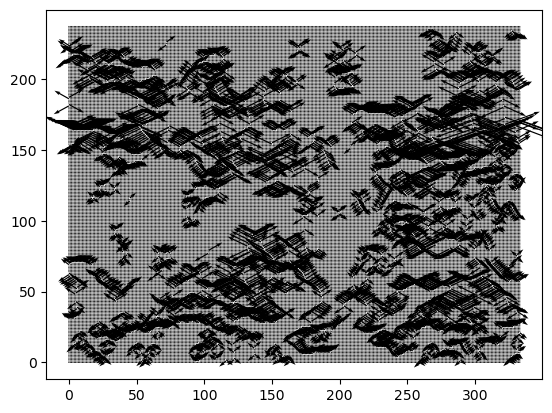

In [8]:

# Resize the initial velocity field
n0, m0 = ux0.shape
n1, m1 = I1.shape
scale = round((n1 * m1 / (n0 * m0)) ** 0.5)
ux0 = zoom(ux0, scale)
uy0 = zoom(uy0, scale)

# Generate the shifted image and calculate velocity difference iteratively
ux = ux0
uy = uy0
print(f"Initial velocity field min/max: {np.min(ux):.4f}/{np.max(ux):.4f}, {np.min(uy):.4f}/{np.max(uy):.4f}")

k = 1
while k <= no_iteration:
    print(f"\nIteration {k}/{no_iteration}")
    print("Shifting image based on velocity field...")
    Im1_shift, uxI, uyI = shift_image_fun_refine_1(ux, uy, I1, I2)
    print(f"Shifted image shape: {Im1_shift.shape}")
    print(f"Intermediate velocity field min/max: {np.min(uxI):.4f}/{np.max(uxI):.4f}, {np.min(uyI):.4f}/{np.max(uyI):.4f}")

    I1 = Im1_shift.astype(np.float64)
    I2 = I2.astype(np.float64)

    print("Calculating optical flow...")
    dux, duy, vor, dux_horn, duy_horn, error2 = OpticalFlowPhysics_fun(I1, I2, lambda_1, lambda_2)
    print(f"Optical flow correction min/max: {np.min(dux):.4f}/{np.max(dux):.4f}, {np.min(duy):.4f}/{np.max(duy):.4f}")

    ux_corr = uxI + dux
    uy_corr = uyI + duy
    print(f"Corrected velocity field min/max: {np.min(ux_corr):.4f}/{np.max(ux_corr):.4f}, {np.min(uy_corr):.4f}/{np.max(uy_corr):.4f}")

    fig, ax = plt.subplots(1,1)
    ax.quiver(ux_corr, uy_corr)
    plt.show()

    k += 1



Final velocity field shape: (238, 334)
Final velocity field min/max: -0.0022/0.0022, -0.0007/0.0007
Cleaning up edges...
After edge cleanup min/max: -0.0022/0.0022, -0.0007/0.0007

Creating plots...
Original image shapes: (238, 334), (238, 334)
Velocity field shape for quiver plot: (238, 334), (238, 334)
Using step size 9 for quiver plot
Quiver grid shape: (27, 38), (27, 38)
Velocity magnitude min/max: 0.0000/0.0023
Displaying plots...


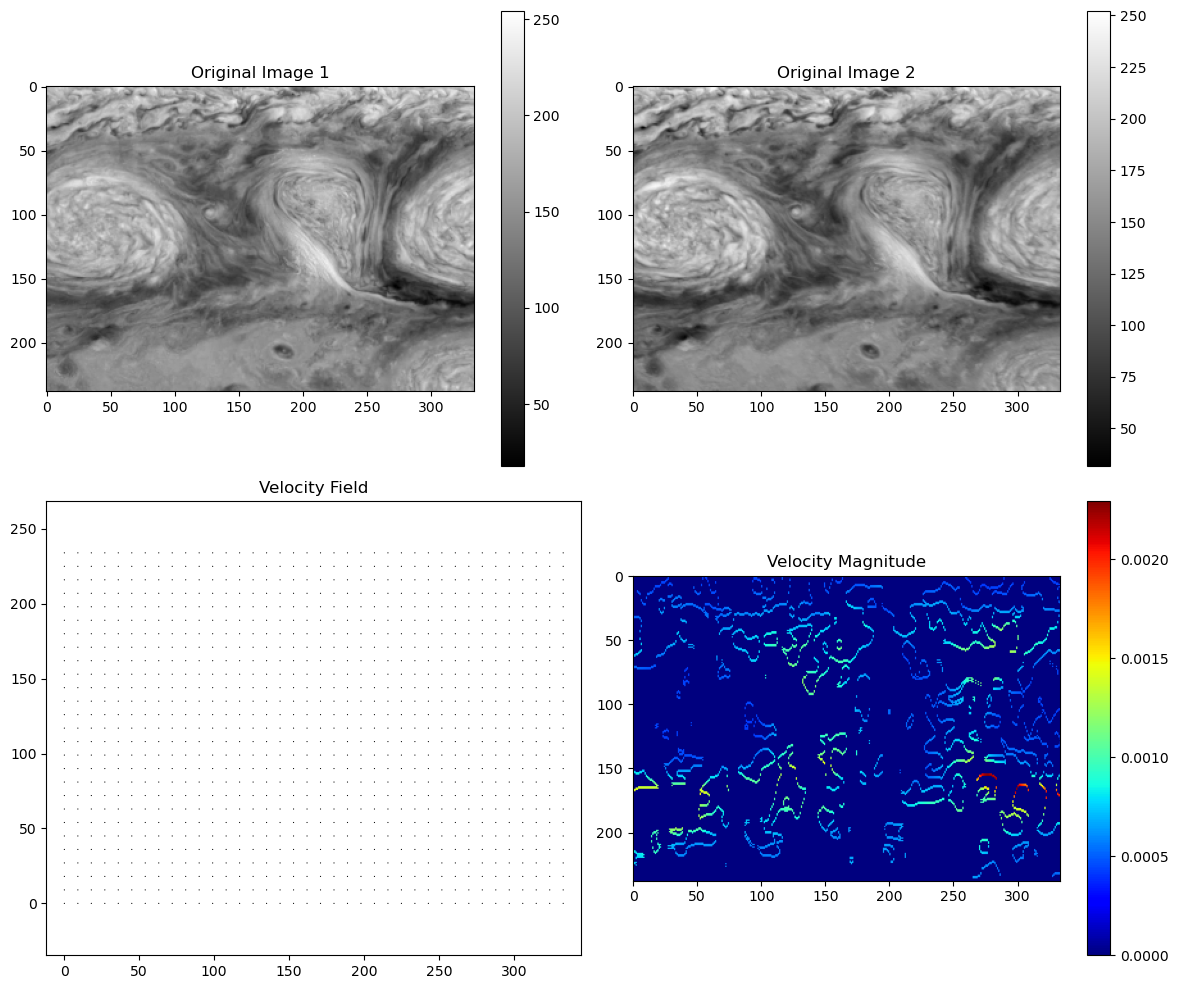

In [9]:
# Refined velocity field
ux = ux_corr
uy = uy_corr
print(f"\nFinal velocity field shape: {ux.shape}")
print(f"Final velocity field min/max: {np.min(ux):.4f}/{np.max(ux):.4f}, {np.min(uy):.4f}/{np.max(uy):.4f}")

# Clean up the edges
print("Cleaning up edges...")
ux[:, :edge_width] = ux[:, edge_width:2*edge_width]
uy[:, :edge_width] = uy[:, edge_width:2*edge_width]
ux[:edge_width, :] = ux[edge_width:2*edge_width, :]
uy[:edge_width, :] = uy[edge_width:2*edge_width, :]
print(f"After edge cleanup min/max: {np.min(ux):.4f}/{np.max(ux):.4f}, {np.min(uy):.4f}/{np.max(uy):.4f}")

# Plot the results
print("\nCreating plots...")
# Create plots similar to plots_set_1 and plots_set_2
plt.figure(figsize=(12, 10))

# Plot original images
print(f"Original image shapes: {I1_original.shape}, {I2_original.shape}")
plt.subplot(2, 2, 1)
plt.imshow(I1_original, cmap='gray')
plt.title('Original Image 1')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(I2_original, cmap='gray')
plt.title('Original Image 2')
plt.colorbar()

# Plot velocity field
print(f"Velocity field shape for quiver plot: {ux.shape}, {uy.shape}")
plt.subplot(2, 2, 3)
# Use a downsampled version for quiver to avoid overcrowding
step = max(1, min(ux.shape) // 25)  # Adjust step size based on array size
print(f"Using step size {step} for quiver plot")

# Create coordinate grid for quiver plot
y, x = np.mgrid[0:ux.shape[0]:step, 0:ux.shape[1]:step]
print(f"Quiver grid shape: {x.shape}, {y.shape}")

# Plot quiver with proper coordinates
plt.quiver(x, y, ux[::step, ::step], uy[::step, ::step], scale=10, angles='xy', scale_units='xy')
plt.title('Velocity Field')
plt.axis('equal')

# Plot velocity magnitude
velocity_magnitude = np.sqrt(ux**2 + uy**2)
print(f"Velocity magnitude min/max: {np.min(velocity_magnitude):.4f}/{np.max(velocity_magnitude):.4f}")
plt.subplot(2, 2, 4)
plt.imshow(velocity_magnitude, cmap='jet')
plt.title('Velocity Magnitude')
plt.colorbar()

plt.tight_layout()
print("Displaying plots...")
plt.show()

# Save results if needed
# np.savetxt('Ux_vortexpair_hybrid_dt0p2.dat', ux)
# np.savetxt('Uy_vortexpair_hybrid_dt0p2.dat', uy)
# np.savetxt('Ux_vortexpair_corr_dt0p2.dat', ux0)
# np.savetxt('Uy_vortexpair_corr_dt0p2.dat', uy0)

